In [1]:
# include packages and libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

In [2]:
# all functions stolen from lecture

# European call option payoff function
def european_call_payoff(S: float, K: float) -> float:
    return max(S - K, 0.)

# spot tree
def create_spot_tree(spot: float, spot_mult_up: float, spot_mult_down: float, steps: int) -> list[list[float]]:
    previous_level = [spot]
    tree = [previous_level]
    for _ in range(steps):
        new_level = [s * spot_mult_down for s in previous_level]
        new_level += [previous_level[-1] * spot_mult_up]
        tree += [new_level]
        previous_level = new_level
    return tree

# discounted price tree
def create_discounted_price_tree(spot_tree: list[list[float]], discount_factor: float, K: float, diag: int = 0) -> list[list[float]]:
    spot = spot_tree[0][0]
    # only true if initial spot is 1 (?!) ~ it will be
    spot_mult_up = spot_tree[1][-1]
    spot_mult_down = spot_tree[1][0]
    # risk neutral measure
    p_up = ((1 / discount_factor - spot_mult_down) / 
                   (spot_mult_up - spot_mult_down))
    p_down = 1 - p_up
    # number of steps in the tree
    steps = len(spot_tree) - 1
    # copy "hollow" tree
    continuation_value_tree = [[np.nan for _ in level] for level in spot_tree]
    # delta
    if diag > 0:
        print("risk-neutral measure: ")
        print(('%.3f' % p_up, '%.3f' % p_down))
        # initialze delta tree
        # delta makes no sense for leaves
        delta_tree = [[np.nan for _ in level] for level in spot_tree[:-1]]
        
    # going backwards, payoff is known in leaves
    for i in range(len(spot_tree[-1])):
        spot = spot_tree[-1][i]
        discounted_continuation_value = discount_factor ** steps * european_call_payoff(spot, K)
        continuation_value_tree[-1][i] = discounted_continuation_value
    # going forward down the branches of the tree
    for step in range(steps - 1, -1, -1):
        for i in range(len(spot_tree[step])):
            # price
            continuation_value_tree[step][i] = p_up   *  continuation_value_tree[step + 1][i] + p_down *  continuation_value_tree[step + 1][i + 1]
            # delta
            if diag > 0:
                delta_tree[step][i] = ((continuation_value_tree[step + 1][i] - continuation_value_tree[step + 1][i + 1]) / (spot_tree[step + 1][i] - spot_tree[step + 1][i + 1]))
    # print delta tree
    if diag > 0:
        print("delta: ")
        delta_tree_readable = [['%.3f' % e for e in n] for n in delta_tree]
        print(delta_tree_readable)
    # return price tree
    return continuation_value_tree

# balanced tree (forcing risk neutral measure to be 0.5-0.5) down step
def calcBalancedDownStep(spot_mult_up: float, discount_factor: float) -> (float, float):
    return spot_mult_up - 2 * (spot_mult_up - 1 / discount_factor)

In [3]:
# set fixed European call price 
cp = 0.76
# discount factor ~ 1 / df = 1 + r
df = 0.9
# spot price
sp = 1
# strke price = 1
K = 1
# number of steps in the tree
steps = 1

In [4]:
# define function to minimize
# f(u) = [call price - tree price(u)]^2
# the functional form has much freedom though... should be positive (semi?)definite and depend on the price difference
def ToMinimize(spot_mult_up: float, steps: int, K: float) -> float:
    # compute down step for given up step to balance the tree
    spot_mult_down_balanced = calcBalancedDownStep(spot_mult_up, df)
    # create the balanced spot tree
    spot_tree = create_spot_tree(sp, spot_mult_up, spot_mult_down_balanced, steps)
    # create the price tree
    price_tree = create_discounted_price_tree(spot_tree, df, K)
    # define and return the function to minimize
    return (price_tree[0][0] - cp) ** 2

In [5]:
# calibrated up step
# some guess ~ d < 1 + r < u
u0 = 1 / df + 0.5
calib_results = minimize(ToMinimize, u0, args = (steps, K))

In [6]:
# results of the optimization
calib_results

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.2455713730232518e-17
        x: [ 2.689e+00]
      nit: 2
      jac: [-1.589e-10]
 hess_inv: [[ 2.469e+00]]
     nfev: 6
     njev: 3

In [7]:
# calibrated up step
spot_mult_up_calib = calib_results.x[0]

In [8]:
# check
spot_mult_down_balanced = calcBalancedDownStep(spot_mult_up_calib, df)
spot_tree = create_spot_tree(sp, spot_mult_up_calib, spot_mult_down_balanced, steps)
price_tree = create_discounted_price_tree(spot_tree, df, K)
print("Previously set European call price: ", cp)
print("European call price from calibrated model: ", price_tree[0][0])

Previously set European call price:  0.76
European call price from calibrated model:  0.7599999964707347


In [9]:
# varying number of steps
N_steps = range(1, 10)
calib_results_u_N = []
for n in range(len(N_steps)):
    calib_results_u_N.append(minimize(ToMinimize, u0, args = (N_steps[n], K)).x[0])
    
    
# checks
calib_prices_N = []
for n in range(len(N_steps)):
    spot_mult_down_balanced = calcBalancedDownStep(calib_results_u_N[n], df)
    spot_tree = create_spot_tree(sp, calib_results_u_N[n], spot_mult_down_balanced, N_steps[n])
    price_tree = create_discounted_price_tree(spot_tree, df, K)
    calib_prices_N.append(price_tree[0][0])

Text(0, 0.5, 'calibrated up step')

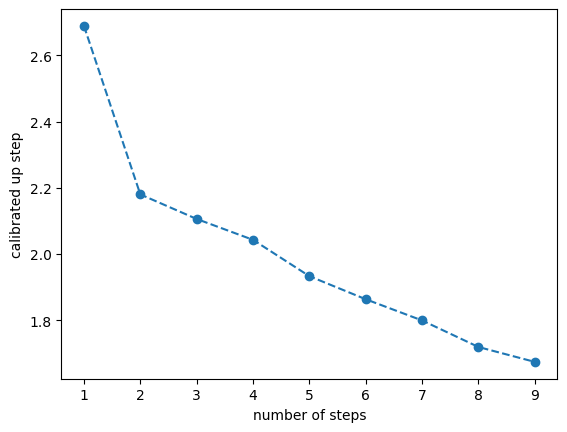

In [10]:
# calibrated up step for different number of steps
plt.plot(N_steps, calib_results_u_N, 'o--')
plt.xlabel("number of steps")
plt.ylabel("calibrated up step")

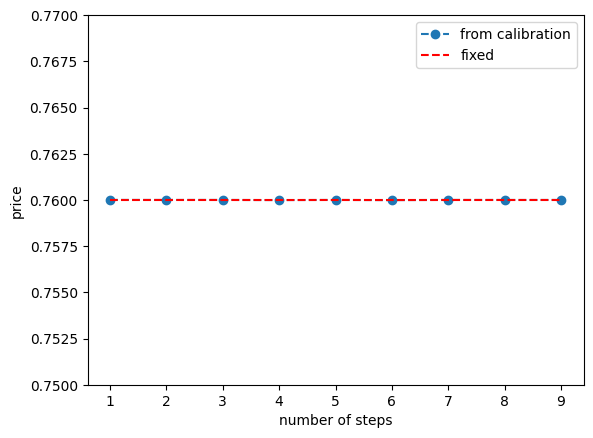

In [11]:
# calibrated up step for different number of steps
plt.plot(N_steps, calib_prices_N, 'o--', label = "from calibration")
plt.xlabel("number of steps")
plt.ylabel("price")
plt.hlines(cp, N_steps[0], N_steps[-1], linestyles = "dashed", color = "r", label = "fixed")
plt.ylim(0.75, 0.77)
plt.legend()

In [12]:
# varying strike prices
# (expiry is implicit here?)
Ks = [1.00, 1.25, 1.50]

calib_results_u_K = []
for k in range(len(Ks)):
    calib_results_u_K.append(minimize(ToMinimize, u0, args = (1, Ks[k])).x[0])
    
# checks
calib_prices_K = []
for k in range(len(Ks)):
    spot_mult_down_balanced = calcBalancedDownStep(calib_results_u_K[k], df)
    spot_tree = create_spot_tree(sp, calib_results_u_K[k], spot_mult_down_balanced, 1)
    price_tree = create_discounted_price_tree(spot_tree, df, Ks[k])
    calib_prices_K.append(price_tree[0][0])

Text(0, 0.5, 'calibrated up step')

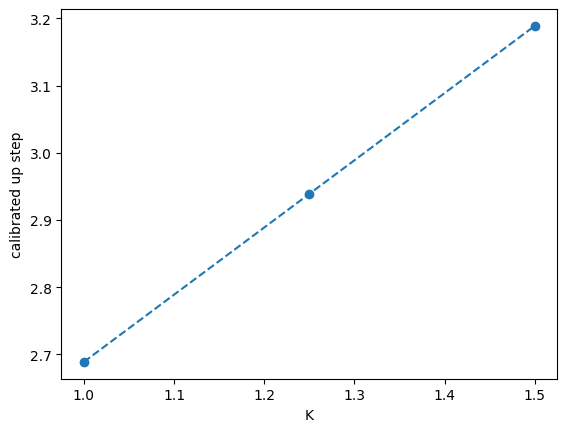

In [13]:
# calibrated up step for different strike prices
plt.plot(Ks, calib_results_u_K, 'o--')
plt.xlabel("K")
plt.ylabel("calibrated up step")

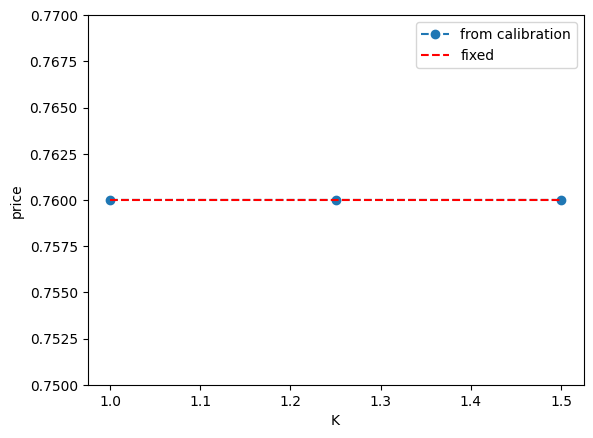

In [14]:
# calibrated up step for different strike prices
plt.plot(Ks, calib_prices_K, 'o--', label = "from calibration")
plt.xlabel("K")
plt.ylabel("price")
plt.hlines(cp, Ks[0], Ks[-1], linestyles = "dashed", color = "r", label = "fixed")
plt.ylim(0.75, 0.77)
plt.legend()